In [26]:
import random
import string
import time
import urllib.request

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data.dataloader as dataloader

In [22]:
# Upload and read the csv files from the github repo
df = pd.read_csv("https://raw.githubusercontent.com/HelenG123/aeye-alliance/master/Labelled%20Data/ting_yi_new_dataset.csv")

print(df.size)
df.head()

2808


,Labeled Data,Label
0,https://firebasestorage.googleapis.com/v0/b/la...,"{""model"":[""a""]}"
1,https://firebasestorage.googleapis.com/v0/b/la...,"{""model"":[""b""]}"
2,https://firebasestorage.googleapis.com/v0/b/la...,"{""model"":[""c""]}"
3,https://firebasestorage.googleapis.com/v0/b/la...,"{""model"":[""d""]}"
4,https://firebasestorage.googleapis.com/v0/b/la...,"{""model"":[""e""]}"


In [20]:
# generate the targets 
# the targets are one hot encoding vectors

# Initalize a target dict that has the letters as its keys and as its value
# an empty one-hot encoding of size 26
target = {_: [0] * 27 for _ in list(string.ascii_lowercase)}

# Do the one-hot encoding for each letter now 
curr_pos = 0 
for letter in target.keys():
    target[letter][curr_pos] = 1
    curr_pos += 1  

# add a space as a "letter" in target
target[' '] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
print(target)

{'a': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'b': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'c': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'd': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'e': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'f': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'g': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'h': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'i': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'j': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'k': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'l': [0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
# collect all data from the csv file
data=[]

# iterate over csv file
for i, row in df.iterrows():
    # store the image and label
    picture = []
    url = row['Labeled Data']
    label = row['Label']
    curr_target = target[label[11]]
    x = urllib.request.urlopen(url)
    resp = x.read()
    image = np.array(bytearray(resp), dtype=np.uint8)
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    # resize image to 28x28x3
    image = cv.resize(image, (28, 28))
    # normalize to 0-1
    image = image.astype(np.float32)/255.0
    image = torch.from_numpy(image)
    picture.append(image)
    # convert the target to a long tensor
    curr_target=torch.LongTensor([curr_target])
    picture.append(curr_target)
    # append the current image & target
    data.append(picture)

In [24]:
len(data)

1404

In [25]:
# shuffle all the data
random.shuffle(data)

# batch sizes for train, test, and validation
batch_size_train = 20
batch_size_test = 5
batch_size_validation = 5

# splitting data to get training, test, and validation sets
# currently splitting my csv file only
# has 1404 in total
# 140 each for test and train
# 1124 for train
train_dataset = data[:1124]
# test has 164
test_dataset = data[1124:1264]
# validation has 164
validation_dataset = data[1264:]

In [27]:
# create the dataloader objects
train_loader = dataloader.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = dataloader.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)
validation_loader = dataloader.DataLoader(dataset=validation_dataset, batch_size=batch_size_validation, shuffle=True)

In [32]:
# defines the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            #3x28x28
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            #16x28x28
            nn.MaxPool2d(kernel_size=2),
            #16x14x14
            nn.LeakyReLU()
        )
        #16x14x14
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            #32x14x14
            nn.MaxPool2d(kernel_size=2),
            #32x7x7
            nn.LeakyReLU()
        ) 
        # linearly 
        self.block3 = nn.Sequential(
            nn.Linear(32*7*7, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 27)
        )
        
        #1x26
    
    def forward(self, x): 
        out = self.block1(x)
        out = self.block2(out)
        # flatten the dataset
        out = out.reshape(-1, 32*7*7)
        out = self.block3(out)
        
        return out


In [33]:
# convolutional neural network model
model = CNN()

# print summary of the neural network model to check if everything is fine. 
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=27, bias=True)
  )
)
# parameter:  173675


In [34]:
# setting the learning rate
learning_rate = 1e-3

# Using a variable to store the cross entropy method
criterion = nn.CrossEntropyLoss()

# Using a variable to store the optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

t0 = time.time()

# list of all train_losses in 30 epochs
train_losses = []
# list of all validation losses in 30 epochs
validation_losses = []

# total train losses
total_train_losses = []
# total validation losses
total_validation_losses = []

In [38]:
# for loop that iterates over all the epochs
num_epochs = 20
for epoch in range(num_epochs):
    
    # variables to store/keep track of the loss and number of iterations
    train_loss = 0
    num_iter_train = 0

    # train the model
    model.train()
    
    # Iterate over train_loader
    for i, (images, labels) in enumerate(train_loader):  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Zero the gradient buffer
        # resets the gradient after each epoch so that the gradients don't add up
        optimizer.zero_grad()  

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors into integer values 
        labels = labels.view(-1, 27)
        y_true = torch.argmax(labels, 1)

        loss = criterion(outputs, y_true)

        #print('loss:', loss)
        total_train_losses.append(loss)
        # Backward (computes all the gradients)
        loss.backward()

        # Optimize
        # loops through all parameters and updates weights by using the gradients 
        # takes steps backwards to optimize (to reach the minimum weight)
        optimizer.step()
        # update the training loss and number of iterations
        train_loss += loss.item()
        num_iter_train += 1

    print('Epoch: {}'.format(epoch+1))
    print('Training Loss: {:.4f}'.format(train_loss/num_iter_train))
    # append the train_losses over all the epochs
    train_losses.append(train_loss/num_iter_train)
    
    # variables to store/keep track of the loss and number of iterations
    validation_loss = 0
    num_iter_validation = 0
    
    # Iterate over train_loader
    for i, (images, labels) in enumerate(validation_loader):  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)
        # print(images.shape)

        # Zero the gradient buffer
        # resets the gradient after each epoch so that the gradients don't add up
        optimizer.zero_grad()  

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors to integer values
        labels = labels.view(-1, 27)
        y_true = torch.argmax(labels, 1)
        # calculate the loss
        loss = criterion(outputs, y_true)
        #print('loss:', loss)
        total_validation_losses.append(loss)

        # update the training loss and number of iterations
        validation_loss += loss.item()
        num_iter_validation += 1

    print('Validation Loss: {:.4f}'.format(validation_loss/num_iter_validation))
    # append all validation_losses over all the epochs
    validation_losses.append(validation_loss/num_iter_validation)
    
    # evaluate the model
    model.eval()

    correct = 0
    total = 0
    num_iter_test = 0
    mean = 0
    
    # Iterate over test_loader
    for images, labels in test_loader:  

        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors into integer values 
        labels = labels.view(-1, 27)
        y_true = torch.argmax(labels, 1)

        # find the index of the prediction
        y_pred = torch.argmax(outputs, 1).type('torch.FloatTensor')
        # convert to FloatTensor
        y_true = y_true.type('torch.FloatTensor')

        # find the mean difference of the comparisons
        mean += torch.mean(torch.eq(y_true, y_pred).type('torch.FloatTensor'))  

    print('Accuracy on the test set: {:.4f}%'.format(mean/len(test_loader) * 100))


Epoch: 1
Training Loss: 3.1832
Validation Loss: 2.8214
Accuracy on the test set: 18.5714%
Epoch: 2
Training Loss: 1.7022
Validation Loss: 0.8907
Accuracy on the test set: 78.5714%
Epoch: 3
Training Loss: 0.6312
Validation Loss: 0.5909
Accuracy on the test set: 87.8571%
Epoch: 4
Training Loss: 0.3803
Validation Loss: 0.4096
Accuracy on the test set: 88.5714%
Epoch: 5
Training Loss: 0.2992
Validation Loss: 0.4737
Accuracy on the test set: 85.7143%
Epoch: 6
Training Loss: 0.2430
Validation Loss: 0.4072
Accuracy on the test set: 89.2857%
Epoch: 7
Training Loss: 0.1849
Validation Loss: 0.3669
Accuracy on the test set: 91.4286%
Epoch: 8
Training Loss: 0.1785
Validation Loss: 0.3614
Accuracy on the test set: 89.2857%
Epoch: 9
Training Loss: 0.1653
Validation Loss: 0.1909
Accuracy on the test set: 92.8571%
Epoch: 10
Training Loss: 0.1127
Validation Loss: 0.3221
Accuracy on the test set: 92.1429%
Epoch: 11
Training Loss: 0.1227
Validation Loss: 0.3807
Accuracy on the test set: 91.4286%
Epoch: 1

In [39]:
# calculate time it took to train the model
tf = time.time()
print()
print("time: {} s" .format(tf-t0))


time: 275.88590574264526 s


In [40]:
# learning curve function
def plot_learning_curve(train_losses, validation_losses):
    # plot the training and validation losses
    # x-axis is the number of training steps
    # y-axis is loss
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.plot(train_losses, label="training")
    plt.plot(validation_losses, label="validation")
    plt.legend(loc=1)

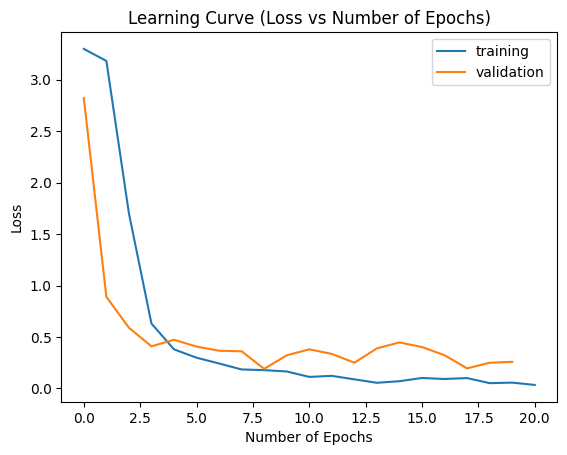

In [41]:
# plot the learning curve
plt.title("Learning Curve (Loss vs Number of Epochs)")
plot_learning_curve(train_losses, validation_losses)